# Predicting Water Potability

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

In [2]:
safe_water_df = pd.read_csv('water_potability.csv')

In [3]:
safe_water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Check value counts to see if classes are balanced

In [4]:
safe_water_df.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

## Check for missingness

In [5]:
safe_water_df.isna().any()

ph                  True
Hardness           False
Solids             False
Chloramines        False
Sulfate             True
Conductivity       False
Organic_carbon     False
Trihalomethanes     True
Turbidity          False
Potability         False
dtype: bool

In [6]:
print("pH % missing = ", round(len(safe_water_df[safe_water_df.ph.isnull()]) /len(safe_water_df),2))
print("Sulphate % missing = ", round(len(safe_water_df[safe_water_df.Sulfate.isnull()]) /len(safe_water_df),2))
print("Trihalomethanes % missing = ", round(len(safe_water_df[safe_water_df.Trihalomethanes.isnull()]) /len(safe_water_df),2))

pH % missing =  0.15
Sulphate % missing =  0.24
Trihalomethanes % missing =  0.05


### Impute data to handle NaNs

In [7]:
# Note: To ensure we do not overfit, we must train the imputer on only the training set, then we can fit it on the entire dataset.

X = safe_water_df.drop(['Potability'], axis = 1)
y = safe_water_df.Potability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X_train)
imputed_data = imp_mean.transform(safe_water_df.iloc[:,:-1])

In [9]:
tmp_df = pd.DataFrame(data = imputed_data, columns = safe_water_df.columns[:-1] )
tmp_df['Potability'] = safe_water_df.Potability
safe_water_df = tmp_df.copy()

In [10]:
safe_water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080687,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.395374,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.395374,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [11]:
safe_water_df.isna().any()

ph                 False
Hardness           False
Solids             False
Chloramines        False
Sulfate            False
Conductivity       False
Organic_carbon     False
Trihalomethanes    False
Turbidity          False
Potability         False
dtype: bool

## We no longer have missing data! (: 

## Let's standardize our data to simplify model fitting

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(safe_water_df)
scaled_data = scaler.transform(safe_water_df)
scaled_safe_water_df = pd.DataFrame(scaled_data, columns=safe_water_df.columns)

In [13]:
scaled_safe_water_df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.505763,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.580618,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.580618,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0


## Fit the model

In [14]:
# Prep Data

X = scaled_safe_water_df.drop(['Potability'], axis = 1)
y = scaled_safe_water_df.Potability

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


In [15]:
# Fit out models here

logReg = LogisticRegression(random_state=0).fit(X, y)
RF = RandomForestClassifier(max_depth=2, random_state=0).fit(X,y)
GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                max_depth=1, random_state=0).fit(X_train, y_train)

classifiers = list(zip(['Logistic Regression', 'Random Forest Classifier', 'Gradient Boosted Classifier'],
                       [logReg, RF, GB]))

In [16]:
for mtype, model in classifiers:
    
    print(f'{mtype}')
    print(f'Train score: {round(model.score(X_train, y_train), 3)}')
    print(f'Test score: {round(model.score(X_test, y_test), 3)}')
    
    probs = model.predict_proba(X_test)[:,1]
    score = average_precision_score(y_test, probs)
    print(f'Avg Precision Score {round(score, 3)}' )
    print('')

Logistic Regression
Train score: 0.605
Test score: 0.628
Avg Precision Score 0.416

Random Forest Classifier
Train score: 0.624
Test score: 0.639
Avg Precision Score 0.519

Gradient Boosted Classifier
Train score: 0.673
Test score: 0.623
Avg Precision Score 0.45



## Plot the PR-Curve

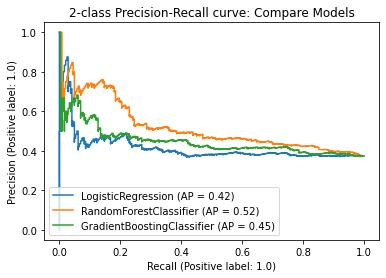

In [17]:
fig = plt.figure()
ax = fig.gca()
ax.set_title('2-class Precision-Recall curve: Compare Models')

for mtype, model in classifiers:
    disp = plot_precision_recall_curve(model, X_test, y_test, ax=ax)

In [18]:
# Save out graph

fig.savefig('Potability_PR_Curve.jpg')

### The Random Forest Model appears to be the optimal model here based on the PR-Curve.